# Image Preprocessing

### Import libraries.

In [1]:
import os
import sys
import tarfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import numpy as np
import h5py
from collections import Counter
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
def load_metadata(filename):
    try:
        print('Loading %s ...' % (filename))
        with open(filename, 'rb') as f:
            metadata = pickle.load(f)
        print('Loading done.')
    except Exception as e:
        metadata = -1
        print('Unable to process data from', filename, ':', e)
    return metadata

In [3]:
train_metadata = load_metadata('train_metadata.pickle')
test_metadata = load_metadata('test_metadata.pickle')
extra_metadata = load_metadata('extra_metadata.pickle')

Loading train_metadata.pickle ...
Loading done.
Loading test_metadata.pickle ...
Loading done.
Loading extra_metadata.pickle ...
Loading done.


In [4]:
train_metadata_np = {'length': np.array(train_metadata['length']),
                     'image':np.array(train_metadata['image']),
                     'label':np.array(train_metadata['label']),
                     'top':np.array(train_metadata['top']),
                     'left':np.array(train_metadata['left']),
                     'width':np.array(train_metadata['width']),
                     'height':np.array(train_metadata['height'])
                    }

extra_metadata_np = {'length': np.array(extra_metadata['length']),
                       'image':np.array(extra_metadata['image']),
                       'label':np.array(extra_metadata['label']),
                       'top':np.array(extra_metadata['top']),
                       'left':np.array(extra_metadata['left']),
                       'width':np.array(extra_metadata['width']),
                       'height':np.array(extra_metadata['height'])
                    }

test_metadata_np = {'length': np.array(test_metadata['length']),
                       'image':np.array(test_metadata['image']),
                       'label':np.array(test_metadata['label']),
                       'top':np.array(test_metadata['top']),
                       'left':np.array(test_metadata['left']),
                       'width':np.array(test_metadata['width']),
                       'height':np.array(test_metadata['height'])
                   }

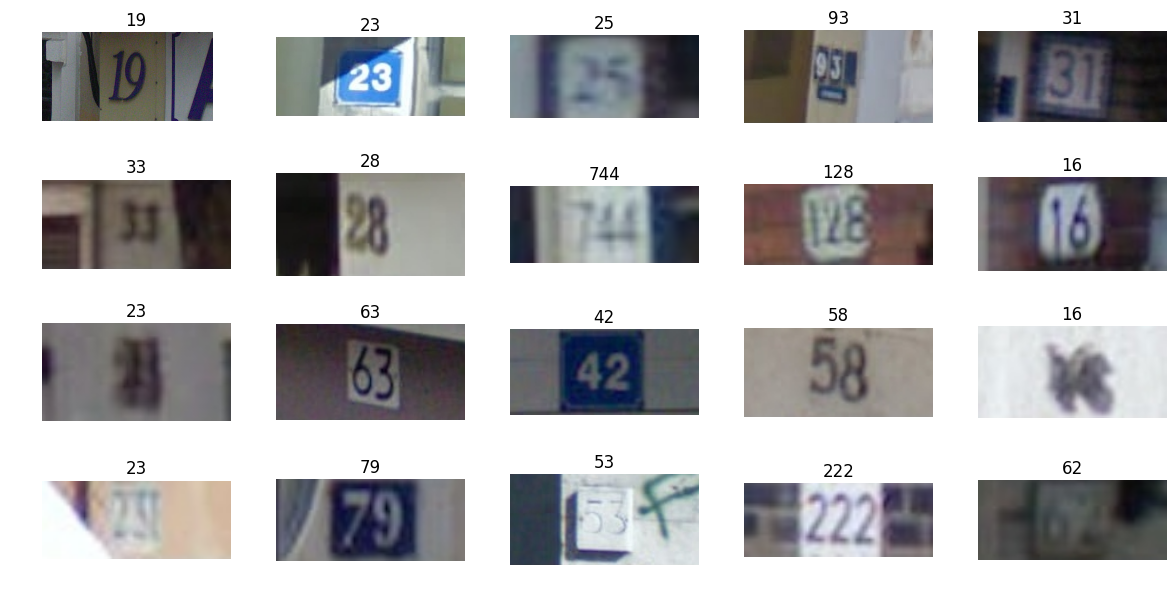

In [5]:
fig = plt.figure(figsize=(12, 6))
rows = 4
columns = 5
for i in range(rows*columns):
    image_file=train_metadata['image'][i]
    image_label=train_metadata['label'][i]
    label_string = ""
    for j in range(len(image_label)):
        label_string+=str(int(image_label[j]))
    img = mpimg.imread(os.path.join('./train/', image_file))
    fig.add_subplot(rows, columns, i+1)
    plt.title(label_string)
    plt.axis("off")
    plt.imshow(img)
plt.tight_layout()
plt.show()

In [6]:
class Bbox(object):
    def __init__(self, Left, Top, Width, Height):
        self.Left = int(Left)
        self.Top = int(Top)
        self.Width = int(Width)
        self.Height = int(Height)
    def __iter__(self):
        return self
    def __repr__(self):
        return "Left: %s\nTop: %s\nWidth: %s\nHeight: %s"%(self.Left,self.Top,self.Width,self.Height)
    def __str__(self):
        return "Left: %s\nTop: %s\nWidth: %s\nHeight: %s"%(self.Left,self.Top,self.Width,self.Height)

In [7]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def subtract_mean(image):
    return image - np.mean(image)

In [8]:
def show_image_with_multi_bbox(metadata, index, path, gray=False, bbox=True):
    image_file=metadata['image'][index]
    top=metadata['top'][index]
    left=metadata['left'][index]
    width=metadata['width'][index]
    height=metadata['height'][index]
    image_label=metadata['label'][index]
        
    label_string = ""
    for j in range(len(image_label)):
        label_string+=str(int(image_label[j]))
    
    img = mpimg.imread(os.path.join(path, image_file))
    if (gray):
        img=rgb2gray(img)
    image_width=img.shape[1]
    image_height=img.shape[0]
    
    print('Image label: %s' % label_string)
    print('Image size: %s x %s' %(image_width,image_height))

    fig, ax = plt.subplots(1)
    plt.title(label_string)
    plt.axis("off")
    if (gray):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
    if (bbox):
        for j in range(len(left)):
            b = Rectangle((left[j], top[j]),
                                     width[j],
                                     height[j],
                                     fill=False)   
            ax.add_patch(b)

def get_image_and_bbox(metadata, index, path, expand_percent=0.3, show = True):
    image_file=metadata['image'][index]
    top=metadata['top'][index]
    left=metadata['left'][index]
    width=metadata['width'][index]
    height=metadata['height'][index]
    image_label=metadata['label'][index]
    
    label_string = ""
    for j in range(len(image_label)):
        label_string+=str(int(image_label[j]))
    
    img = mpimg.imread(os.path.join(path, image_file))
    img = rgb2gray(img*255)
    image_width=img.shape[1]
    image_height=img.shape[0]
    
    # compute new bounding box
    bottom=top+height
    right=left+width
    bboxTop=min(top)
    bboxLeft=min(left)
    bboxBottom=max(bottom)
    bboxRight=max(right)
    bboxWidth=bboxRight - bboxLeft
    bboxHeight=bboxBottom - bboxTop
    
    # expand bounding box by 'expand_percent'
    expand_x=bboxWidth*expand_percent/2.0
    expand_y=bboxHeight*expand_percent/2.0
    bboxTop_=round(bboxTop-expand_y)
    if (bboxTop_<0):
        bboxTopExpand=0
    else:
        bboxTopExpand=bboxTop_

    bboxLeft_=round(bboxLeft-expand_x)
    if (bboxLeft_<0):
        bboxLeftExpand=0
    else:
        bboxLeftExpand=bboxLeft_

    bboxBottom_=round(bboxBottom+expand_y)
    if (bboxBottom_>image_height-1):
        bboxBottomExpand=image_height-1
    else:
        bboxBottomExpand=bboxBottom_

    bboxRight_=round(bboxRight+expand_x)
    if (bboxRight_>image_width-1):
        bboxRightExpand=image_width-1
    else:
        bboxRightExpand=bboxRight_

    bboxWidthExpand=bboxRightExpand-bboxLeftExpand
    bboxHeightExpand=bboxBottomExpand-bboxTopExpand
    
    bbox = Bbox(bboxLeftExpand, bboxTopExpand, bboxWidthExpand, bboxHeightExpand)
    
    bbox_small = []
    for i in range(len(top)):
        bbox_small.append(Bbox(left[i],top[i],width[i],height[i]))

    if (show == True):
        print('Image label: %s' % label_string)
        print('Image size: %s x %s' %(image_width,image_height))
        fig, ax = plt.subplots(1)
        plt.title("Image with single bounding box")
        plt.axis("off")
        plt.imshow(img,cmap='gray')
        bbox_rect = Rectangle((bboxLeftExpand, bboxTopExpand),
                                      bboxWidthExpand,
                                      bboxHeightExpand,
                                      fill=False)   
        ax.add_patch(bbox_rect)
        for j in range(len(left)):
            b = Rectangle((left[j], top[j]),
                                     width[j],
                                     height[j],
                                     fill=False)   
            ax.add_patch(b)
        
    return img, bbox, bbox_small

In [9]:
itemindex = np.argwhere(np.array(train_metadata['length'])==5).reshape(-1)
print(itemindex)

[ 4110  6738 15957 18262 18943 24040 24551 26698 33228]


Image label: 17661
Image size: 164 x 56


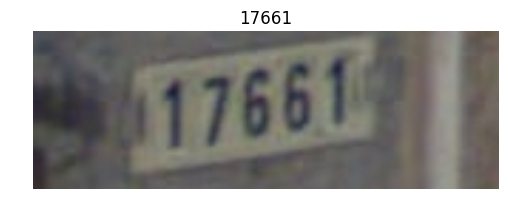

In [10]:
show_image_with_multi_bbox(train_metadata, itemindex[0], './train',gray=False,bbox=False)

Image label: 17661
Image size: 164 x 56


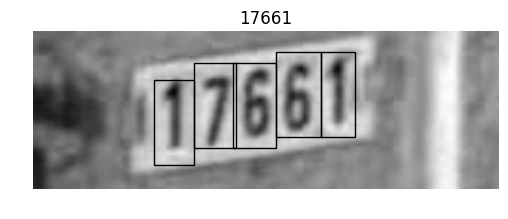

In [11]:
show_image_with_multi_bbox(train_metadata, itemindex[0], './train',gray=True,bbox=True)

Image label: 17661
Image size: 164 x 56


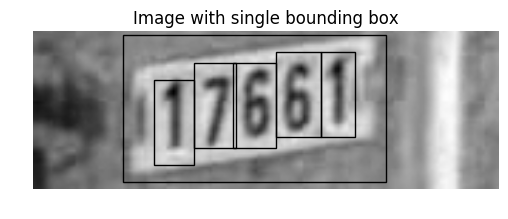

In [12]:
img, bbox, bbox_small = get_image_and_bbox(train_metadata, itemindex[0], './train/', expand_percent=0.3, show=True)

Range of grey values: (30.106, 156.843).


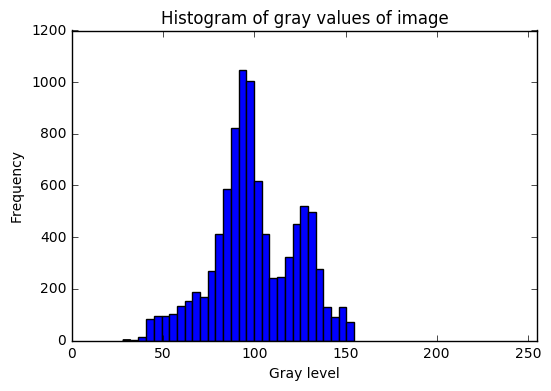

In [13]:
img_gray=img
image_1d=img_gray.reshape(-1)
print('Range of grey values: (%s, %s).' %(min(image_1d),max(image_1d)))
n, bins, patches = plt.hist(image_1d, bins=30, align='left')
plt.axis([-0,255,0,1200])
plt.title("Histogram of gray values of image")
plt.ylabel("Frequency")
plt.xlabel("Gray level")
plt.show()

Range of grey values: (-72.3016238023, 54.4353761977).


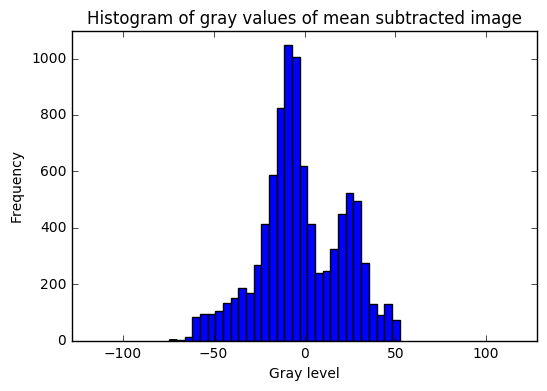

In [14]:
image_subtract=subtract_mean(img_gray)
image_subtract_1d=image_subtract.reshape(-1)
print('Range of grey values: (%s, %s).' %(min(image_subtract_1d),max(image_subtract_1d)))
n, bins, patches = plt.hist(image_subtract_1d, bins=30, align='left')
plt.axis([-128,128,0,1100])
plt.title("Histogram of gray values of mean subtracted image")
plt.ylabel("Frequency")
plt.xlabel("Gray level")
plt.show()

In [15]:
def crop_image_with_bbox(image, bbox, bbox_small):
    right=bbox.Left+bbox.Width-1
    bottom=bbox.Top+bbox.Height-1
    
    bbox_small_new=[]
    for i in range(len(bbox_small)):
        small_left = bbox_small[i].Left-bbox.Left
        small_top = bbox_small[i].Top-bbox.Top
        small_width = bbox_small[i].Width
        small_height = bbox_small[i].Height
        
        if small_left<0:
            small_left=0
        if small_top<0:
            small_top=0
        if small_left>=bbox.Width-1:
            small_left=bbox.Width-1
        if small_top>=bbox.Height-1:
            small_top=bbox.Height-1
        
        small_right = small_left+small_width-1
        small_bottom = small_top+small_height-1
        
        if small_right>=bbox.Width-1:
            small_width = bbox.Width-small_left
        if small_bottom>=bbox.Height-1:
            small_height = bbox.Height-small_top
            
        bbox_small_new.append(Bbox(small_left,small_top,small_width,small_height))
    
    return image[bbox.Top:bottom+1, bbox.Left:right+1], bbox_small_new

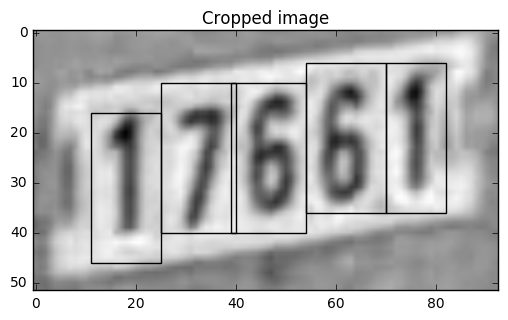

In [16]:
img_cropped, bbox_cropped = crop_image_with_bbox(img, bbox, bbox_small)

fig, ax = plt.subplots(1)
plt.title("Cropped image")
plt.imshow(img_cropped,cmap='gray')
for j in range(len(bbox_cropped)):
    b = Rectangle((bbox_cropped[j].Left, bbox_cropped[j].Top),
                             bbox_cropped[j].Width,
                             bbox_cropped[j].Height,
                             fill=False)   
    ax.add_patch(b)

In [17]:
def resize_image_with_bbox(image, shape, bbox):
    row_scale = float(shape[0])/image.shape[0]
    col_scale = float(shape[1])/image.shape[1]
    image_resized = imresize(image, shape)
    
    bbox_new = []
    for i in range(len(bbox)):
        l = bbox[i].Left*col_scale
        t = bbox[i].Top*row_scale
        w = bbox[i].Width*col_scale
        h = bbox[i].Height*row_scale
        bbox_new.append(Bbox(l,t,w,h))
    
    return image_resized, bbox_new

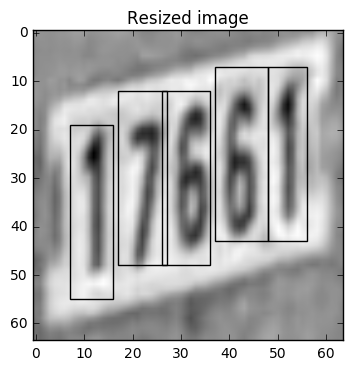

In [18]:
img_resized, bbox_resized = resize_image_with_bbox(img_cropped, (64,64), bbox_cropped)

fig, ax = plt.subplots(1)
plt.title("Resized image")
plt.imshow(img_resized,cmap='gray')
for j in range(len(bbox_resized)):
    b = Rectangle((bbox_resized[j].Left, bbox_resized[j].Top),
                             bbox_resized[j].Width,
                             bbox_resized[j].Height,
                             fill=False)   
    ax.add_patch(b)

In [19]:
def random_crop(image, bbox_digit, count, show=True):
    '''Randomly crop 54x54 image from a 64x64 image.'''
    np.random.seed(121)
    
    Width=54
    Height=54
    Left_Offset= Width/2.
    Top_Offset= Height/2.
    
    possible_center_min_xy = 27
    possible_center_max_xy = 36
    possible_center_xy_range = possible_center_max_xy - possible_center_min_xy + 1

    ys=np.array([-1])
    xs=np.array([-1])
    for i in range(possible_center_min_xy, possible_center_max_xy+1):
        ys=np.append(ys,np.ones(possible_center_xy_range, dtype=int)*i)
        xs=np.append(xs,np.arange(possible_center_min_xy, possible_center_max_xy+1))
    ys=ys[1:]
    xs=xs[1:]

    if (show==True):
        cols=5
        rows=(count-1)/cols + 1
        fig = plt.figure(figsize=(10, rows*2))
    
    images=[]
    bbox_digit_new_list = []
    for i in range(count):
        index = np.random.choice(range(possible_center_xy_range * possible_center_xy_range))
        Left=xs[index]-Left_Offset
        Top=ys[index]-Top_Offset
        bbox=Bbox(Left, Top, Width, Height)
        image_cropped, bbox_digit_new =crop_image_with_bbox(image, bbox, bbox_digit)
        images.append(image_cropped)
        bbox_digit_new_list.append(bbox_digit_new)
        
        if (show==True):
            print('#%s - index=%s, y=%s, x=%s' % (i+1,index,ys[index],xs[index]))
            ax = fig.add_subplot(rows, cols, i+1)
            plt.title(str(i+1))
            plt.axis("off")
            plt.imshow(image_cropped,cmap='gray')
            for j in range(len(bbox_digit_new)):
                b = Rectangle((bbox_digit_new[j].Left, bbox_digit_new[j].Top),
                                         bbox_digit_new[j].Width,
                                         bbox_digit_new[j].Height,
                                         fill=False)   
                ax.add_patch(b)
        
    return images, bbox_digit_new_list

#1 - index=66, y=33, x=33
#2 - index=85, y=35, x=32
#3 - index=8, y=27, x=35
#4 - index=95, y=36, x=32
#5 - index=65, y=33, x=32
#6 - index=52, y=32, x=29
#7 - index=83, y=35, x=30
#8 - index=96, y=36, x=33
#9 - index=46, y=31, x=33
#10 - index=34, y=30, x=31
#11 - index=52, y=32, x=29
#12 - index=60, y=33, x=27
#13 - index=54, y=32, x=31
#14 - index=3, y=27, x=30
#15 - index=94, y=36, x=31
#16 - index=52, y=32, x=29
#17 - index=57, y=32, x=34
#18 - index=75, y=34, x=32
#19 - index=88, y=35, x=35
#20 - index=39, y=30, x=36


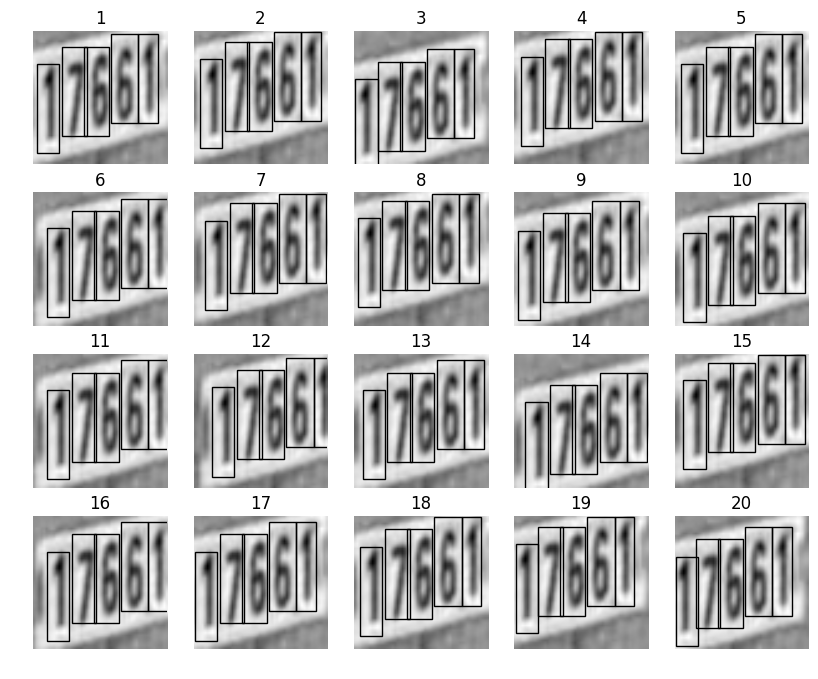

In [20]:
cropped_images, bbox_digit_list=random_crop(img_resized, bbox_resized, 20, show=True)

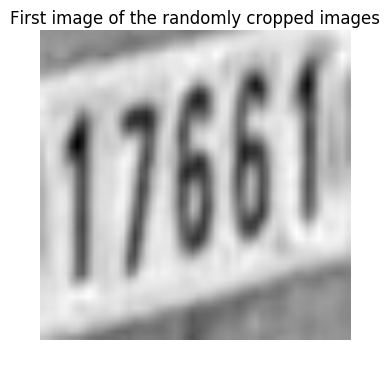

In [21]:
fig=plt.figure()
plt.title("First image of the randomly cropped images")
plt.axis("off")
plt.imshow(cropped_images[0],cmap='gray')
plt.show()

In [22]:
def gaussian_noise(image, sd_factor):
    return image + sd_factor*image.std()*np.random.random(image.shape)

In [23]:
image_subtract=subtract_mean(cropped_images[0])

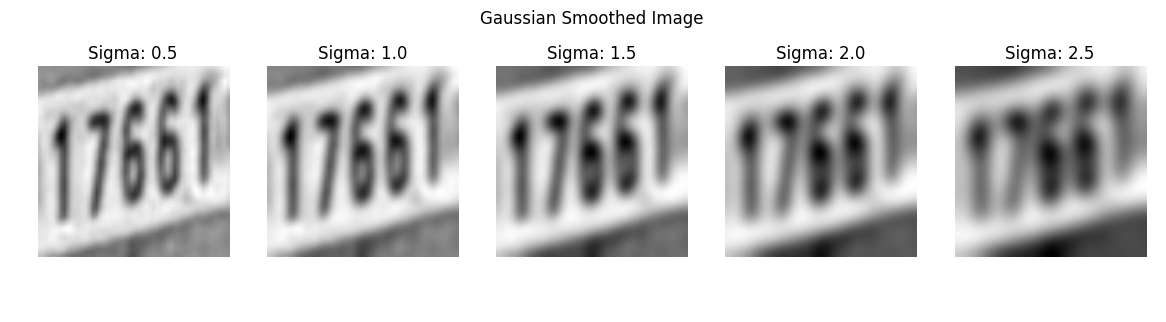

In [24]:
sigma = [0.5,1.0,1.5,2.0,2.5]

fig = plt.figure(figsize=(12, 3))
plt.title("Gaussian Smoothed Image")
plt.axis("off")
rows = 1
columns = 5
for i in range(rows*columns):
    img = ndimage.filters.gaussian_filter(image_subtract,sigma[i])
    fig.add_subplot(rows, columns, i+1)
    plt.title('Sigma: %s'%str(sigma[i]))
    plt.axis("off")
    plt.imshow(img,cmap='gray')
plt.tight_layout()
plt.show()

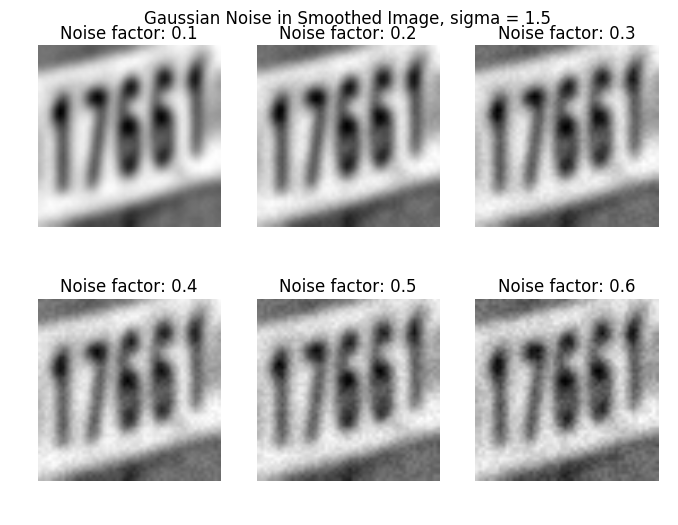

In [25]:
noise_sd_factor = [0.1,0.2,0.3,0.4,0.5,0.6]

fig2 = plt.figure(figsize=(8, 6))
plt.title("Gaussian Noise in Smoothed Image, sigma = 1.5")
plt.axis("off")
rows = 2
columns = 3
for i in range(rows*columns):
    img = ndimage.filters.gaussian_filter(image_subtract,1.5)
    img = gaussian_noise(img,noise_sd_factor[i])
    fig2.add_subplot(rows, columns, i+1)
    plt.title('Noise factor: %s'%str(noise_sd_factor[i]))
    plt.axis("off")
    plt.imshow(img,cmap='gray')
plt.show()

In [26]:
def maybe_extract_features_labels(metadata, path, label_length, random_crop_count, gauss_smooth, gauss_noise, 
                                  filename, force=False):
    image_size = 32
    image_channel = 1
    label_length = label_length*np.ones((1))
    
    if os.path.exists(filename + '.pickle') and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extracting. Loading pickle file instead.' % (filename + '.pickle'))
        try:
            print('Loading %s ...' % (filename + '.pickle'))
            with open(filename + '.pickle', 'rb') as f:
                data = pickle.load(f)
            print('Loading done.')
        except Exception as e:
            data = -1
            print('Unable to process data from', filename, ':', e)
    
    else:
        print('Extracting features and labels ...' )
    
        digit_count=5
        length=len(metadata['image'])

        data = {}
        features=np.zeros((1,image_size,image_size,image_channel),dtype = np.float32)
        labels=np.zeros((1,digit_count),dtype = np.int32)
        top=np.zeros((1,digit_count),dtype = np.int32)
        left=np.zeros((1,digit_count),dtype = np.int32)
        width=np.zeros((1,digit_count),dtype = np.int32)
        height=np.zeros((1,digit_count),dtype = np.int32)
        digit_length=np.zeros((1),dtype = np.int32)
        image_path=[]

        for i in range(length):
            # initialize all digit to blank character initially.
            tmp_label=np.ones((1,digit_count),dtype=np.int32)*10
            
            # replace with available information from metadata
            for j in range(label_length):
                tmp_label[0,j]=metadata['label'][i][j]
                
            tmp_image_path = os.path.join(path,metadata['image'][i])
                
            
            img, bbox, bbox_small = get_image_and_bbox(metadata, i, path, expand_percent=0.3, show=False)
            img_cropped, bbox_cropped = crop_image_with_bbox(img, bbox, bbox_small)
            img_resized, bbox_resized = resize_image_with_bbox(img_cropped, (64,64), bbox_cropped)
            cropped_images, bbox_digit_list=random_crop(img_resized, bbox_resized, random_crop_count,show=False)
            
            # for each of the randomly cropped image, append the features and labels
            for j in range(len(cropped_images)):
                final_resize, final_bbox =resize_image_with_bbox(cropped_images[j], (image_size,image_size), 
                                                                 bbox_digit_list[j])
                
                # initialize all bounding box info to 0 initially.
                tmp_top=np.zeros((1,digit_count),dtype=np.float32)
                tmp_left=np.zeros((1,digit_count),dtype=np.float32)
                tmp_width=np.zeros((1,digit_count),dtype=np.float32)
                tmp_height=np.zeros((1,digit_count),dtype=np.float32)
                
                for k in range(len(final_bbox)):
                    tmp_top[0,k]=final_bbox[k].Top
                    tmp_left[0,k]=final_bbox[k].Left
                    tmp_width[0,k]=final_bbox[k].Width
                    tmp_height[0,k]=final_bbox[k].Height
                
                sub_mean = subtract_mean(final_resize)
                
                if (len(gauss_smooth)!=0 and len(gauss_noise)!=0):
                    for sigma in gauss_smooth:
                        smooth = ndimage.filters.gaussian_filter(sub_mean,sigma)

                        for sd_factor in gauss_noise:
                            feature = gaussian_noise(smooth, sd_factor)
                            feature = feature.reshape((1,image_size,image_size,image_channel))
                            features = np.concatenate((features,feature),axis=0)
                            labels = np.concatenate((labels,tmp_label),axis=0)
                            top = np.concatenate((top,tmp_top),axis=0)
                            left = np.concatenate((left,tmp_left),axis=0)
                            width = np.concatenate((width,tmp_width),axis=0)
                            height = np.concatenate((height,tmp_height),axis=0)
                            digit_length = np.concatenate((digit_length,label_length),axis=0)
                            image_path.append(tmp_image_path)
                else:
                    feature = sub_mean
                    feature = feature.reshape((1,image_size,image_size,image_channel))
                    features = np.concatenate((features,feature),axis=0)
                    labels = np.concatenate((labels,tmp_label),axis=0)
                    top = np.concatenate((top,tmp_top),axis=0)
                    left = np.concatenate((left,tmp_left),axis=0)
                    width = np.concatenate((width,tmp_width),axis=0)
                    height = np.concatenate((height,tmp_height),axis=0)
                    digit_length = np.concatenate((digit_length,label_length),axis=0)
                    image_path.append(tmp_image_path)
                
            if (i % 500 == 0):
                print('%s / %s elapsed.'% (i,length))
                print('%s items concatenated.'% (features.shape[0]-1))

        data['features']=features[1:,:,:,:]
        data['labels']=labels[1:,:]
        data['top']=top[1:,:]
        data['left']=left[1:,:]
        data['width']=width[1:,:]
        data['height']=height[1:,:]
        data['digit_length']=digit_length[1:]
        data['image']=image_path
        
        print('Extracting done.')
        print('Pickling %s ...' % (filename + '.pickle'))
        try:
            with open(filename + '.pickle', 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to',  filename + '.pickle', ':', e)
        print('Pickling done.')
        
    return data

In [27]:
def filter_metadata_by_len(metadata, length):
    indices = np.argwhere(metadata['length']==length)
    indices = indices.reshape(indices.shape[0])

    metadata_filtered = {'length': metadata['length'][indices],
                           'image':metadata['image'][indices],
                           'label':metadata['label'][indices],
                           'top':metadata['top'][indices],
                           'left':metadata['left'][indices],
                           'width':metadata['width'][indices],
                           'height':metadata['height'][indices]}
    return metadata_filtered
def sample(index_list, n):
    length = index_list.shape[0]
    indices = np.array([np.random.choice(length) for k in range(n)])
    return index_list[indices]

def filter_metadata_by_len_sampling(metadata, length, n_sample):
    indices = np.argwhere(metadata['length']==length)
    indices = indices.reshape(indices.shape[0])
    sampled_indices = sample(indices,n_sample)

    metadata_filtered = {'length': metadata['length'][sampled_indices],
                           'image':metadata['image'][sampled_indices],
                           'label':metadata['label'][sampled_indices],
                           'top':metadata['top'][sampled_indices],
                           'left':metadata['left'][sampled_indices],
                           'width':metadata['width'][sampled_indices],
                           'height':metadata['height'][sampled_indices]}
    return metadata_filtered

In [28]:
train_metadata_len_1 = filter_metadata_by_len(train_metadata_np,1)
train_data_len_1 = maybe_extract_features_labels(train_metadata_len_1, './train', label_length=1, 
                                                 random_crop_count=2, gauss_smooth=[], 
                                                 gauss_noise=[], filename='train_data_len_1', 
                                                 force=False)

Extracting features and labels ...
0 / 5137 elapsed.
2 items concatenated.
500 / 5137 elapsed.
1002 items concatenated.
1000 / 5137 elapsed.
2002 items concatenated.
1500 / 5137 elapsed.
3002 items concatenated.
2000 / 5137 elapsed.
4002 items concatenated.
2500 / 5137 elapsed.
5002 items concatenated.
3000 / 5137 elapsed.
6002 items concatenated.
3500 / 5137 elapsed.
7002 items concatenated.
4000 / 5137 elapsed.
8002 items concatenated.
4500 / 5137 elapsed.
9002 items concatenated.
5000 / 5137 elapsed.
10002 items concatenated.
Extracting done.
Pickling train_data_len_1.pickle ...
Pickling done.


In [29]:
extra_metadata_len_1 = filter_metadata_by_len(extra_metadata_np,1)
extra_data_len_1 = maybe_extract_features_labels(extra_metadata_len_1, './extra', label_length=1, 
                                                 random_crop_count=2, gauss_smooth=[], 
                                                 gauss_noise=[], filename='extra_data_len_1', 
                                                 force=False)

Extracting features and labels ...
0 / 9385 elapsed.
2 items concatenated.
500 / 9385 elapsed.
1002 items concatenated.
1000 / 9385 elapsed.
2002 items concatenated.
1500 / 9385 elapsed.
3002 items concatenated.
2000 / 9385 elapsed.
4002 items concatenated.
2500 / 9385 elapsed.
5002 items concatenated.
3000 / 9385 elapsed.
6002 items concatenated.
3500 / 9385 elapsed.
7002 items concatenated.
4000 / 9385 elapsed.
8002 items concatenated.
4500 / 9385 elapsed.
9002 items concatenated.
5000 / 9385 elapsed.
10002 items concatenated.
5500 / 9385 elapsed.
11002 items concatenated.
6000 / 9385 elapsed.
12002 items concatenated.
6500 / 9385 elapsed.
13002 items concatenated.
7000 / 9385 elapsed.
14002 items concatenated.
7500 / 9385 elapsed.
15002 items concatenated.
8000 / 9385 elapsed.
16002 items concatenated.
8500 / 9385 elapsed.
17002 items concatenated.
9000 / 9385 elapsed.
18002 items concatenated.
Extracting done.
Pickling extra_data_len_1.pickle ...
Pickling done.


In [30]:
print('Total training samples of length 1: %s'\
      %(train_data_len_1['digit_length'].shape[0] + extra_data_len_1['digit_length'].shape[0]))

Total training samples of length 1: 29044


In [31]:
train_metadata_len_2 = filter_metadata_by_len(train_metadata_np,2)
train_data_len_2 = maybe_extract_features_labels(train_metadata_len_2, './train', label_length=2, 
                                                 random_crop_count=1, gauss_smooth=[], 
                                                 gauss_noise=[], filename='train_data_len_2', 
                                                 force=False)

Extracting features and labels ...
0 / 18130 elapsed.
1 items concatenated.
500 / 18130 elapsed.
501 items concatenated.
1000 / 18130 elapsed.
1001 items concatenated.
1500 / 18130 elapsed.
1501 items concatenated.
2000 / 18130 elapsed.
2001 items concatenated.
2500 / 18130 elapsed.
2501 items concatenated.
3000 / 18130 elapsed.
3001 items concatenated.
3500 / 18130 elapsed.
3501 items concatenated.
4000 / 18130 elapsed.
4001 items concatenated.
4500 / 18130 elapsed.
4501 items concatenated.
5000 / 18130 elapsed.
5001 items concatenated.
5500 / 18130 elapsed.
5501 items concatenated.
6000 / 18130 elapsed.
6001 items concatenated.
6500 / 18130 elapsed.
6501 items concatenated.
7000 / 18130 elapsed.
7001 items concatenated.
7500 / 18130 elapsed.
7501 items concatenated.
8000 / 18130 elapsed.
8001 items concatenated.
8500 / 18130 elapsed.
8501 items concatenated.
9000 / 18130 elapsed.
9001 items concatenated.
9500 / 18130 elapsed.
9501 items concatenated.
10000 / 18130 elapsed.
10001 item

In [32]:
extra_metadata_len_2 = filter_metadata_by_len_sampling(extra_metadata_np,2,11870)
extra_data_len_2 = maybe_extract_features_labels(extra_metadata_len_2, './extra', label_length=2, 
                                                 random_crop_count=1, gauss_smooth=[], 
                                                 gauss_noise=[], filename='extra_data_len_2', 
                                                 force=False)

Extracting features and labels ...
0 / 11870 elapsed.
1 items concatenated.
500 / 11870 elapsed.
501 items concatenated.
1000 / 11870 elapsed.
1001 items concatenated.
1500 / 11870 elapsed.
1501 items concatenated.
2000 / 11870 elapsed.
2001 items concatenated.
2500 / 11870 elapsed.
2501 items concatenated.
3000 / 11870 elapsed.
3001 items concatenated.
3500 / 11870 elapsed.
3501 items concatenated.
4000 / 11870 elapsed.
4001 items concatenated.
4500 / 11870 elapsed.
4501 items concatenated.
5000 / 11870 elapsed.
5001 items concatenated.
5500 / 11870 elapsed.
5501 items concatenated.
6000 / 11870 elapsed.
6001 items concatenated.
6500 / 11870 elapsed.
6501 items concatenated.
7000 / 11870 elapsed.
7001 items concatenated.
7500 / 11870 elapsed.
7501 items concatenated.
8000 / 11870 elapsed.
8001 items concatenated.
8500 / 11870 elapsed.
8501 items concatenated.
9000 / 11870 elapsed.
9001 items concatenated.
9500 / 11870 elapsed.
9501 items concatenated.
10000 / 11870 elapsed.
10001 item

In [33]:
print('Total training samples of length 2: %s'\
      %(train_data_len_2['digit_length'].shape[0] + extra_data_len_2['digit_length'].shape[0]))

Total training samples of length 2: 30000


In [34]:
train_metadata_len_3 = filter_metadata_by_len(train_metadata_np,3)
train_data_len_3 = maybe_extract_features_labels(train_metadata_len_3, './train', label_length=3, 
                                                 random_crop_count=1, gauss_smooth=[], 
                                                 gauss_noise=[], filename='train_data_len_3', 
                                                 force=False)

Extracting features and labels ...
0 / 8691 elapsed.
1 items concatenated.
500 / 8691 elapsed.
501 items concatenated.
1000 / 8691 elapsed.
1001 items concatenated.
1500 / 8691 elapsed.
1501 items concatenated.
2000 / 8691 elapsed.
2001 items concatenated.
2500 / 8691 elapsed.
2501 items concatenated.
3000 / 8691 elapsed.
3001 items concatenated.
3500 / 8691 elapsed.
3501 items concatenated.
4000 / 8691 elapsed.
4001 items concatenated.
4500 / 8691 elapsed.
4501 items concatenated.
5000 / 8691 elapsed.
5001 items concatenated.
5500 / 8691 elapsed.
5501 items concatenated.
6000 / 8691 elapsed.
6001 items concatenated.
6500 / 8691 elapsed.
6501 items concatenated.
7000 / 8691 elapsed.
7001 items concatenated.
7500 / 8691 elapsed.
7501 items concatenated.
8000 / 8691 elapsed.
8001 items concatenated.
8500 / 8691 elapsed.
8501 items concatenated.
Extracting done.
Pickling train_data_len_3.pickle ...
Pickling done.


In [35]:
extra_metadata_len_3 = filter_metadata_by_len_sampling(extra_metadata_np,3,21309)
extra_data_len_3 = maybe_extract_features_labels(extra_metadata_len_3, './extra', label_length=3, 
                                                 random_crop_count=1, gauss_smooth=[], 
                                                 gauss_noise=[], filename='extra_data_len_3', 
                                                 force=False)

Extracting features and labels ...
0 / 21309 elapsed.
1 items concatenated.
500 / 21309 elapsed.
501 items concatenated.
1000 / 21309 elapsed.
1001 items concatenated.
1500 / 21309 elapsed.
1501 items concatenated.
2000 / 21309 elapsed.
2001 items concatenated.
2500 / 21309 elapsed.
2501 items concatenated.
3000 / 21309 elapsed.
3001 items concatenated.
3500 / 21309 elapsed.
3501 items concatenated.
4000 / 21309 elapsed.
4001 items concatenated.
4500 / 21309 elapsed.
4501 items concatenated.
5000 / 21309 elapsed.
5001 items concatenated.
5500 / 21309 elapsed.
5501 items concatenated.
6000 / 21309 elapsed.
6001 items concatenated.
6500 / 21309 elapsed.
6501 items concatenated.
7000 / 21309 elapsed.
7001 items concatenated.
7500 / 21309 elapsed.
7501 items concatenated.
8000 / 21309 elapsed.
8001 items concatenated.
8500 / 21309 elapsed.
8501 items concatenated.
9000 / 21309 elapsed.
9001 items concatenated.
9500 / 21309 elapsed.
9501 items concatenated.
10000 / 21309 elapsed.
10001 item

In [36]:
print('Total training samples of length 3: %s'\
      %(train_data_len_3['digit_length'].shape[0] + extra_data_len_3['digit_length'].shape[0]))

Total training samples of length 3: 30000


In [37]:
train_metadata_len_4 = filter_metadata_by_len(train_metadata_np,4)
train_data_len_4 = maybe_extract_features_labels(train_metadata_len_4, './train', label_length=4, 
                                                 random_crop_count=2, gauss_smooth=[], 
                                                 gauss_noise=[], filename='train_data_len_4', 
                                                 force=False)

Extracting features and labels ...
0 / 1434 elapsed.
2 items concatenated.
500 / 1434 elapsed.
1002 items concatenated.
1000 / 1434 elapsed.
2002 items concatenated.
Extracting done.
Pickling train_data_len_4.pickle ...
Pickling done.


In [38]:
extra_metadata_len_4 = filter_metadata_by_len(extra_metadata_np,4)
extra_data_len_4 = maybe_extract_features_labels(extra_metadata_len_4, './extra', label_length=4, 
                                                 random_crop_count=2, gauss_smooth=[], 
                                                 gauss_noise=[], filename='extra_data_len_4', 
                                                 force=False)

Extracting features and labels ...
0 / 14338 elapsed.
2 items concatenated.
500 / 14338 elapsed.
1002 items concatenated.
1000 / 14338 elapsed.
2002 items concatenated.
1500 / 14338 elapsed.
3002 items concatenated.
2000 / 14338 elapsed.
4002 items concatenated.
2500 / 14338 elapsed.
5002 items concatenated.
3000 / 14338 elapsed.
6002 items concatenated.
3500 / 14338 elapsed.
7002 items concatenated.
4000 / 14338 elapsed.
8002 items concatenated.
4500 / 14338 elapsed.
9002 items concatenated.
5000 / 14338 elapsed.
10002 items concatenated.
5500 / 14338 elapsed.
11002 items concatenated.
6000 / 14338 elapsed.
12002 items concatenated.
6500 / 14338 elapsed.
13002 items concatenated.
7000 / 14338 elapsed.
14002 items concatenated.
7500 / 14338 elapsed.
15002 items concatenated.
8000 / 14338 elapsed.
16002 items concatenated.
8500 / 14338 elapsed.
17002 items concatenated.
9000 / 14338 elapsed.
18002 items concatenated.
9500 / 14338 elapsed.
19002 items concatenated.
10000 / 14338 elapsed.

In [39]:
print('Total training samples of length 4: %s'\
      %(train_data_len_4['digit_length'].shape[0] + extra_data_len_4['digit_length'].shape[0]))

Total training samples of length 4: 31544


In [40]:
train_metadata_len_5 = filter_metadata_by_len(train_metadata_np,5)
train_data_len_5 = maybe_extract_features_labels(train_metadata_len_5, './train', label_length=5, 
                                                 random_crop_count=40, gauss_smooth=[1.5,2.0], 
                                                 gauss_noise=[0.2,0.3,0.4], filename='train_data_len_5', 
                                                 force=False)

Extracting features and labels ...
0 / 9 elapsed.
240 items concatenated.
Extracting done.
Pickling train_data_len_5.pickle ...
Pickling done.


In [41]:
extra_metadata_len_5 = filter_metadata_by_len(extra_metadata_np,5)
extra_data_len_5 = maybe_extract_features_labels(extra_metadata_len_5, './extra', label_length=5, 
                                                 random_crop_count=40, gauss_smooth=[1.5,2.0], 
                                                 gauss_noise=[0.2,0.3,0.4], filename='extra_data_len_5', 
                                                 force=False)

Extracting features and labels ...
0 / 115 elapsed.
240 items concatenated.
Extracting done.
Pickling extra_data_len_5.pickle ...
Pickling done.


In [42]:
print('Total training samples of length 5: %s'\
      %(train_data_len_5['digit_length'].shape[0] + extra_data_len_5['digit_length'].shape[0]))

Total training samples of length 5: 29760


In [43]:
length_train = np.concatenate((train_data_len_1['digit_length'],
                             extra_data_len_1['digit_length'],
                             train_data_len_2['digit_length'],
                             extra_data_len_2['digit_length'],
                             train_data_len_3['digit_length'],
                             extra_data_len_3['digit_length'],
                             train_data_len_4['digit_length'],
                             extra_data_len_4['digit_length'],
                             train_data_len_5['digit_length'],
                             extra_data_len_5['digit_length']),
                            axis=0)

labels_train = np.concatenate((train_data_len_1['labels'],
                             extra_data_len_1['labels'],
                             train_data_len_2['labels'],
                             extra_data_len_2['labels'],
                             train_data_len_3['labels'],
                             extra_data_len_3['labels'],
                             train_data_len_4['labels'],
                             extra_data_len_4['labels'],
                             train_data_len_5['labels'],
                             extra_data_len_5['labels']),
                            axis=0)

top_train = np.concatenate((train_data_len_1['top'],
                             extra_data_len_1['top'],
                             train_data_len_2['top'],
                             extra_data_len_2['top'],
                             train_data_len_3['top'],
                             extra_data_len_3['top'],
                             train_data_len_4['top'],
                             extra_data_len_4['top'],
                             train_data_len_5['top'],
                             extra_data_len_5['top']),
                            axis=0)

left_train = np.concatenate((train_data_len_1['left'],
                             extra_data_len_1['left'],
                             train_data_len_2['left'],
                             extra_data_len_2['left'],
                             train_data_len_3['left'],
                             extra_data_len_3['left'],
                             train_data_len_4['left'],
                             extra_data_len_4['left'],
                             train_data_len_5['left'],
                             extra_data_len_5['left']),
                            axis=0)

width_train = np.concatenate((train_data_len_1['width'],
                             extra_data_len_1['width'],
                             train_data_len_2['width'],
                             extra_data_len_2['width'],
                             train_data_len_3['width'],
                             extra_data_len_3['width'],
                             train_data_len_4['width'],
                             extra_data_len_4['width'],
                             train_data_len_5['width'],
                             extra_data_len_5['width']),
                            axis=0)

height_train = np.concatenate((train_data_len_1['height'],
                             extra_data_len_1['height'],
                             train_data_len_2['height'],
                             extra_data_len_2['height'],
                             train_data_len_3['height'],
                             extra_data_len_3['height'],
                             train_data_len_4['height'],
                             extra_data_len_4['height'],
                             train_data_len_5['height'],
                             extra_data_len_5['height']),
                            axis=0)

image_path_train = train_data_len_1['image'] +\
                    extra_data_len_1['image'] +\
                    train_data_len_2['image'] +\
                    extra_data_len_2['image'] +\
                    train_data_len_3['image'] +\
                    extra_data_len_3['image'] +\
                    train_data_len_4['image'] +\
                    extra_data_len_4['image'] +\
                    train_data_len_5['image'] +\
                    extra_data_len_5['image']

In [44]:
y_train = np.concatenate((length_train.reshape(length_train.shape[0],1),
                          labels_train,
                          top_train,
                          left_train,
                          width_train,
                          height_train)
                         ,axis=1)

In [45]:
def plot_length_hist(data,max_freq,title):
    label_chars=['1','2','3','4','5']
    tickLocations = np.arange(len(label_chars))

    fig, ax = plt.subplots(figsize=(6, 3.5))
    n, bins, patches = plt.hist(data-1, bins=range(0,12), align='left')
    ax.set_xticks(ticks= tickLocations)
    ax.set_xticklabels(label_chars)
    plt.axis([-1,5,0,max_freq])
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Digit sequence length")
    plt.show()
    
def plot_position_hist(data,title,max_freq):
    label_chars=['0','1','2','3','4','5','6','7','8','9','_']
    tickLocations = np.arange(len(label_chars))

    fig, ax = plt.subplots(figsize=(4, 3.5))
    n, bins, patches = plt.hist(data, bins=range(0,12), align='left')
    ax.set_xticks(ticks= tickLocations)
    ax.set_xticklabels(label_chars)
    plt.axis([-1,11,0,max_freq])
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Digit")
    plt.show()

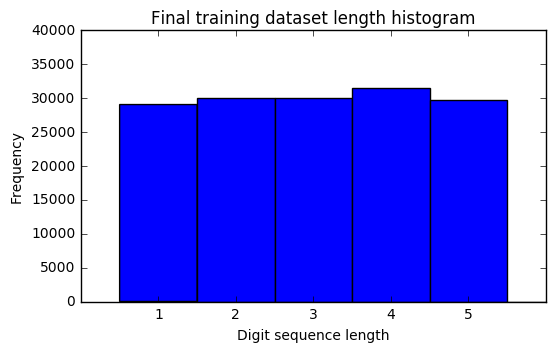

Counter({1.0: 29044, 2.0: 30000, 3.0: 30000, 4.0: 31544, 5.0: 29760})

In [46]:
plot_length_hist(y_train[:,0], 40000, "Final training dataset length histogram")
Counter(y_train[:,0])

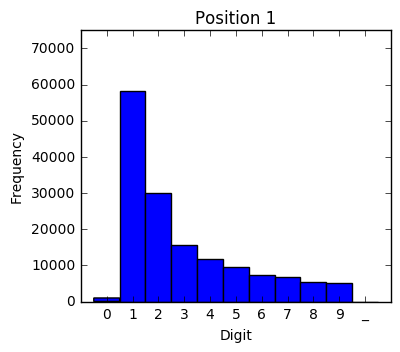

Counter({0.0: 978,
         1.0: 58105,
         2.0: 29873,
         3.0: 15542,
         4.0: 11704,
         5.0: 9511,
         6.0: 7405,
         7.0: 6790,
         8.0: 5302,
         9.0: 5138})

In [47]:
plot_position_hist(y_train[:,1],"Position 1",75000)
Counter(y_train[:,1])

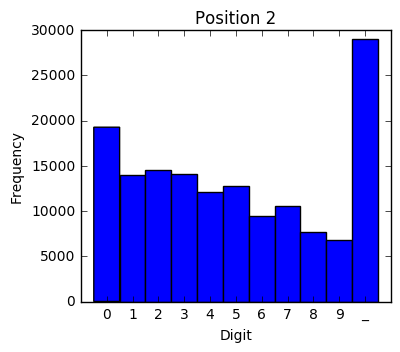

Counter({0.0: 19278,
         1.0: 14030,
         2.0: 14514,
         3.0: 14071,
         4.0: 12117,
         5.0: 12766,
         6.0: 9499,
         7.0: 10582,
         8.0: 7643,
         9.0: 6804,
         10.0: 29044})

In [48]:
plot_position_hist(y_train[:,2],"Position 2",30000)
Counter(y_train[:,2])

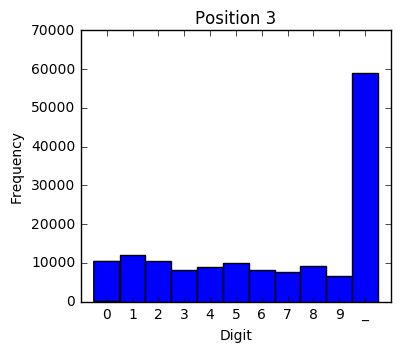

Counter({0.0: 10349,
         1.0: 12057,
         2.0: 10391,
         3.0: 8212,
         4.0: 8897,
         5.0: 9869,
         6.0: 8196,
         7.0: 7669,
         8.0: 9049,
         9.0: 6615,
         10.0: 59044})

In [49]:
plot_position_hist(y_train[:,3],"Position 3",70000)
Counter(y_train[:,3])

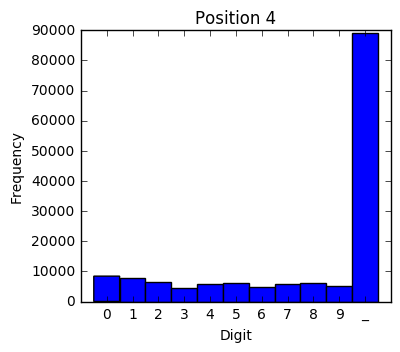

Counter({0.0: 8416,
         1.0: 7770,
         2.0: 6444,
         3.0: 4598,
         4.0: 5954,
         5.0: 6020,
         6.0: 4884,
         7.0: 5868,
         8.0: 6150,
         9.0: 5200,
         10.0: 89044})

In [50]:
plot_position_hist(y_train[:,4],"Position 4",90000)
Counter(y_train[:,4])

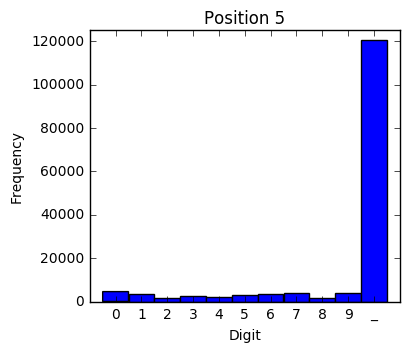

Counter({0.0: 4560,
         1.0: 3360,
         2.0: 1680,
         3.0: 2640,
         4.0: 1920,
         5.0: 2880,
         6.0: 3360,
         7.0: 3840,
         8.0: 1680,
         9.0: 3840,
         10.0: 120588})

In [51]:
plot_position_hist(y_train[:,5],"Position 5",125000)
Counter(y_train[:,5])

In [52]:
X_train = np.concatenate((train_data_len_1['features'],
                        extra_data_len_1['features'],
                        train_data_len_2['features'],
                        extra_data_len_2['features'],
                        train_data_len_3['features'],
                        extra_data_len_3['features'],
                        train_data_len_4['features'],
                        extra_data_len_4['features'],
                        train_data_len_5['features'],
                        extra_data_len_5['features']),
                       axis=0)

In [53]:
print('X_train size:')
print(X_train.shape)
print('')
print('y_train size:')
print(y_train.shape)
print('')
print('image_path_train size:')
print(len(image_path_train))

X_train size:
(150348, 32, 32, 1)

y_train size:
(150348, 26)

image_path_train size:
150348


In [54]:
filename = 'train_data'
data = {'X_train':X_train, 'y_train':y_train, 'image_path_train':image_path_train}
try:
    with open(filename + '.pickle', 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to',  filename + '.pickle', ':', e)
print('Pickling done.')

Pickling done.


In [55]:
test_metadata_len_1 = filter_metadata_by_len(test_metadata_np,1)
test_data_len_1 = maybe_extract_features_labels(test_metadata_len_1, './test', label_length=1, 
                                                 random_crop_count=1, gauss_smooth=[], 
                                                 gauss_noise=[], filename='test_data_len_1', 
                                                 force=False)
test_metadata_len_2 = filter_metadata_by_len(test_metadata_np,2)
test_data_len_2 = maybe_extract_features_labels(test_metadata_len_2, './test', label_length=2, 
                                                 random_crop_count=1, gauss_smooth=[], 
                                                 gauss_noise=[], filename='test_data_len_2', 
                                                 force=False)
test_metadata_len_3 = filter_metadata_by_len(test_metadata_np,3)
test_data_len_3 = maybe_extract_features_labels(test_metadata_len_3, './test', label_length=3, 
                                                 random_crop_count=1, gauss_smooth=[], 
                                                 gauss_noise=[], filename='test_data_len_3', 
                                                 force=False)
test_metadata_len_4 = filter_metadata_by_len(test_metadata_np,4)
test_data_len_4 = maybe_extract_features_labels(test_metadata_len_4, './test', label_length=4, 
                                                 random_crop_count=1, gauss_smooth=[], 
                                                 gauss_noise=[], filename='test_data_len_4', 
                                                 force=False)
test_metadata_len_5 = filter_metadata_by_len(test_metadata_np,5)
test_data_len_5 = maybe_extract_features_labels(test_metadata_len_5, './test', label_length=5, 
                                                 random_crop_count=1, gauss_smooth=[], 
                                                 gauss_noise=[], filename='test_data_len_5', 
                                                 force=False)

Extracting features and labels ...
0 / 2483 elapsed.
1 items concatenated.
500 / 2483 elapsed.
501 items concatenated.
1000 / 2483 elapsed.
1001 items concatenated.
1500 / 2483 elapsed.
1501 items concatenated.
2000 / 2483 elapsed.
2001 items concatenated.
Extracting done.
Pickling test_data_len_1.pickle ...
Pickling done.
Extracting features and labels ...
0 / 8356 elapsed.
1 items concatenated.
500 / 8356 elapsed.
501 items concatenated.
1000 / 8356 elapsed.
1001 items concatenated.
1500 / 8356 elapsed.
1501 items concatenated.
2000 / 8356 elapsed.
2001 items concatenated.
2500 / 8356 elapsed.
2501 items concatenated.
3000 / 8356 elapsed.
3001 items concatenated.
3500 / 8356 elapsed.
3501 items concatenated.
4000 / 8356 elapsed.
4001 items concatenated.
4500 / 8356 elapsed.
4501 items concatenated.
5000 / 8356 elapsed.
5001 items concatenated.
5500 / 8356 elapsed.
5501 items concatenated.
6000 / 8356 elapsed.
6001 items concatenated.
6500 / 8356 elapsed.
6501 items concatenated.
7000

In [56]:
length_test = np.concatenate((test_data_len_1['digit_length'],
                             test_data_len_2['digit_length'],
                             test_data_len_3['digit_length'],
                             test_data_len_4['digit_length'],
                             test_data_len_5['digit_length']),
                            axis=0)
labels_test = np.concatenate((test_data_len_1['labels'],
                             test_data_len_2['labels'],
                             test_data_len_3['labels'],
                             test_data_len_4['labels'],
                             test_data_len_5['labels']),
                            axis=0)
top_test = np.concatenate((test_data_len_1['top'],
                             test_data_len_2['top'],
                             test_data_len_3['top'],
                             test_data_len_4['top'],
                             test_data_len_5['top']),
                            axis=0)
left_test = np.concatenate((test_data_len_1['left'],
                             test_data_len_2['left'],
                             test_data_len_3['left'],
                             test_data_len_4['left'],
                             test_data_len_5['left']),
                            axis=0)
width_test = np.concatenate((test_data_len_1['width'],
                             test_data_len_2['width'],
                             test_data_len_3['width'],
                             test_data_len_4['width'],
                             test_data_len_5['width']),
                            axis=0)
height_test = np.concatenate((test_data_len_1['height'],
                             test_data_len_2['height'],
                             test_data_len_3['height'],
                             test_data_len_4['height'],
                             test_data_len_5['height']),
                            axis=0)
image_path_test = test_data_len_1['image'] +\
                    test_data_len_2['image'] +\
                    test_data_len_3['image'] +\
                    test_data_len_4['image'] +\
                    test_data_len_5['image'] 

In [57]:
y_test = np.concatenate((length_test.reshape(length_test.shape[0],1),
                         labels_test,
                         top_test,
                         left_test,
                         width_test,
                         height_test)
                        ,axis=1)

In [58]:
X_test = np.concatenate((test_data_len_1['features'],
                        test_data_len_2['features'],
                        test_data_len_3['features'],
                        test_data_len_4['features'],
                        test_data_len_5['features']),
                       axis=0)

In [61]:
print('X_test size:')
print(X_test.shape)
print('')
print('y_test size:')
print(y_test.shape)
print('')
print('image_path_test size:')
print(len(image_path_test))

X_test size:
(13068, 32, 32, 1)

y_test size:
(13068, 26)

image_path_test size:
13068


In [60]:
filename = 'test_data'
data = {'X_test':X_test, 'y_test':y_test, 'image_path_test':image_path_test}
try:
    with open(filename + '.pickle', 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to',  filename + '.pickle', ':', e)
print('Pickling done.')

Pickling done.
